In [5]:
import os
import sys
newPath = os.path.dirname(os.path.abspath(""))
if newPath not in sys.path:
    sys.path.append(newPath)

from main import *
m = bi()


jax.local_device_count 32


# Data simulation

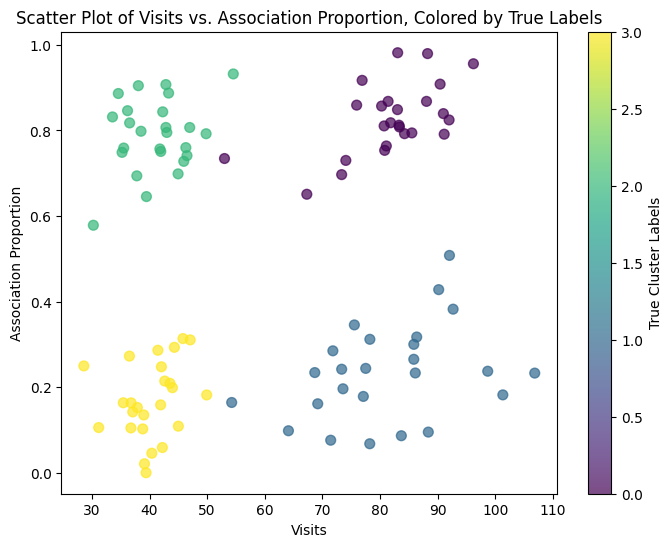

In [2]:
import numpy as np

# Generate synthetic data with Multivariate Normal Distribution
def generate_synthetic_data(n_locations=100,
    cluster_means={
        'visits': [80, 80, 20, 20],
        'assoc_prop': [0.8, 0.2, 0.8, 0.2]
    },
    cluster_stds={
        'visits': [10, 10, 5, 5],
        'assoc_prop': [0.1, 0.1, 0.1, 0.1]
    },
    covariances=[0.5, 0.5, 0.2, 0.2],  # Define covariances for each cluster
    seed=0):
    """Generates synthetic data by creating four clusters with specific mean and standard deviation values for two features (visits and assoc_prop).
    
    Args:
        n_locations (int): Number of locations to generate.
        cluster_means (dict): Contains predefined mean values for each cluster's center for the two features.
        cluster_stds (dict): Contains the standard deviations for each cluster.
        covariances (list): Covariances between 'visits' and 'assoc_prop' for each cluster.
        random_seed (int): Seed for random number generation.
    
    Returns:
        np.array: Generated data points.
        np.array: True labels for each data point.
    """

    np.random.seed(seed)
    n_per_cluster = n_locations // 4
    data = []
    true_labels = []
    
    # Generate data for each cluster
    for i in range(4):
        mean_vector = [cluster_means['visits'][i], cluster_means['assoc_prop'][i]]
        cov_matrix = [
            [cluster_stds['visits'][i] ** 2, covariances[i] * cluster_stds['visits'][i] * cluster_stds['assoc_prop'][i]],
            [covariances[i] * cluster_stds['visits'][i] * cluster_stds['assoc_prop'][i], cluster_stds['assoc_prop'][i] ** 2]
        ]
        
        # Generate n_per_cluster samples from the multivariate normal distribution
        samples = np.random.multivariate_normal(mean_vector, cov_matrix, n_per_cluster)
        
        # Ensure proportions are between 0 and 1
        samples[:, 1] = np.clip(samples[:, 1], 0, 1)
        
        data.extend(samples)
        true_labels.extend([i] * n_per_cluster)
    
    return np.array(data), np.array(true_labels)

# Plotting function remains the same
def plot_synthetic_data(X, true_labels):
    import matplotlib.pyplot as plt

    visits = X[:, 0]
    assoc_prop = X[:, 1]

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(visits, assoc_prop, c=true_labels, cmap='viridis', s=50, alpha=0.7)
    plt.colorbar(scatter, label="True Cluster Labels")
    plt.xlabel("Visits")
    plt.ylabel("Association Proportion")
    plt.title("Scatter Plot of Visits vs. Association Proportion, Colored by True Labels")
    plt.show()

# Generate and plot the data
data, true_labels = generate_synthetic_data(
    seed = 1000,
    cluster_means={
        'visits': [80, 80, 40, 40],
        'assoc_prop': [0.8, 0.2, 0.8, 0.2]
    }
)
plot_synthetic_data(data, true_labels)


# Multivariate Gaussian Mixture Model (GMM)

In [3]:
from main import *
import numpyro
import numpyro.distributions as dists
import jax
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.ops.indexing import Vindex
import numpy as np

m = bi(platform='cpu')
def simData(n = 100, dim = 2, k = 3, p_real = [0.1, 0.5, 0.4], mus = [[10,10], [5,5], [1,1]], sigmas = [1,0.5], seed = 0):
    """
    Simulate data from a mixture of Gaussians.
    
    Parameters
    ----------
    n : int
        Number of samples.
    dim : int
        Dimensionality of the data.
    k : int
        Number of mixture components.
    p_real : array-like, shape (k,)
        Probability of each mixture component.
    sigma : array-like, shape (dim,)
        Standard deviation of the noise.
    mus : array-like, shape (k, dim)
        Means of the mixture components on each dimension.
    sigmas : array-like, shape (k,)
        Standard deviations of the mixture components on each groups.
        
    Returns
    -------
    data : array-like, shape (n, dim)
        Simulated data.
        
    """
    key = jax.random.key(seed)
    seeds = jax.random.randint(key, (100,), 0, 10000)

    mus = jnp.array(mus)
    sigmas = jnp.array(sigmas)
    p_real = jnp.array(p_real)    

    clusters = bi.dist.categorical(probs = p_real, sample = True, shape=(n,))
    s_clusters = sigmas[clusters]
    m_clusters = mus[clusters]
    
    return vmap(lambda x, y, z  : bi.dist.multivariatenormal(x, jnp.diag(jnp.repeat(y, dim)), sample = True, seed = z))(m_clusters, s_clusters, seeds), clusters

def plot_synthetic_data(X, true_labels):
    import matplotlib.pyplot as plt

    visits = X[:, 0]
    assoc_prop = X[:, 1]

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(visits, assoc_prop, c=true_labels, cmap='viridis', s=50, alpha=0.7)
    plt.colorbar(scatter, label="True Cluster Labels")
    plt.xlabel("Visits")
    plt.ylabel("Association Proportion")
    plt.title("Scatter Plot of Visits vs. Association Proportion, Colored by True Labels")
    plt.show()


jax.local_device_count 32


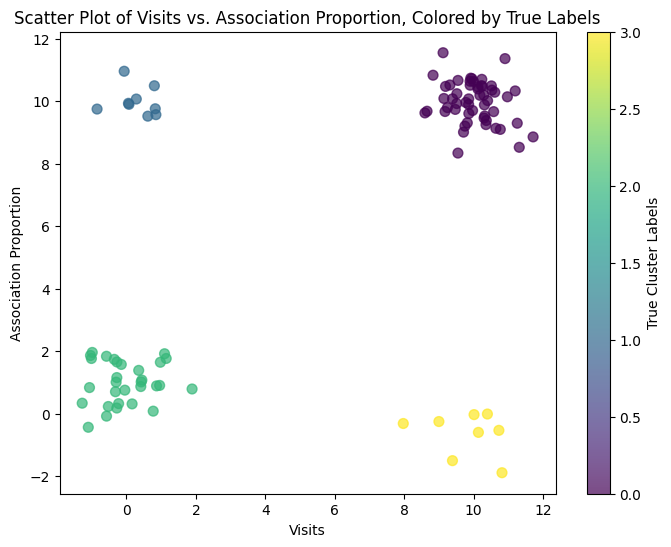

In [4]:
data, true_labels =  simData(n = 100, dim = 2, k = 4, 
p_real = [0.50, 0.10, 0.30, 0.10], 
mus = [[10,10], [0,10], [0,1] , [10,0]], 
sigmas = [0.5,0.5, 0.5,0.5])
plot_synthetic_data(data, true_labels)

In [5]:
N, dim = data.shape
K = 4
sample = True
p_real = [0.25, 0.25, 0.25, 0.25]
mus = jnp.array([[10,10], [0,10], [0,1] , [10,0]])
sigmas = jnp.array([[0.5,0.2], [0.5,0.2], [0.5,0.2] , [0.5,0.2]])
cluster_proba = jnp.array(p_real)

In [7]:

#cluster_proba = bi.dist.dirichlet(weight * jnp.ones(K), sample=sample, name = 'cluster_proba')
cluster_proba = jnp.array(p_real)
#mus = bi.dist.multivariatenormal(0, 10*jnp.eye(dim), sample = sample, shape = (K, ), name= 'locs') # KxD
#sigmas = bi.dist.halfcauchy(scale=10, sample = sample, shape=(K, dim), name = 'sigma')# KxD

assignment = bi.dist.categorical(cluster_proba, sample = sample, shape = (N,), name='assignment')
sigma_expanded = vmap(lambda x: x * jnp.eye(dim) )(sigmas[assignment])
tmp = mus[assignment]
tmp = tmp.reshape(dim, N).T
data = bi.dist.multivariatenormal(tmp, sigma_expanded, sample = True)


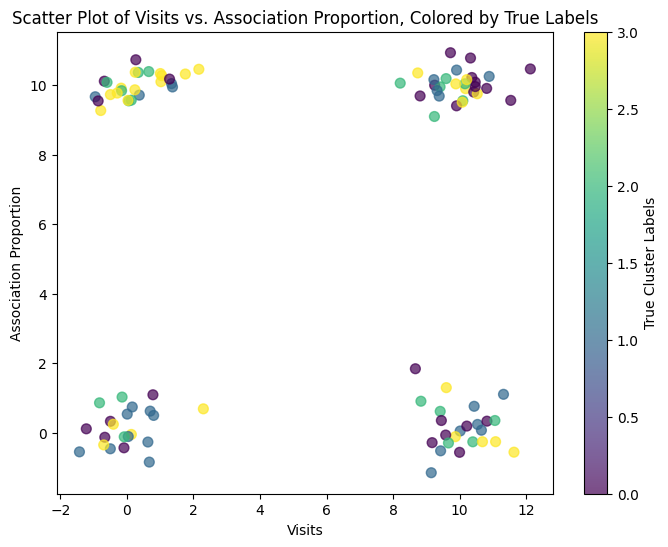

In [8]:
plot_synthetic_data(data, assignment)

#  BI not working

Due to numpyro specificities in latent variable, this can't run with BI, mainly due to plate function.

In [15]:
from numpyro.ops.indexing import Vindex
weight = 0.5
K = 4
def model(data = data, weight = 0.5, K = 4):

    N, dim = data.shape
    cluster_proba = bi.dist.dirichlet(weight * jnp.ones(K), name = 'cluster_proba')
     
    locs = bi.dist.multivariatenormal(jnp.zeros(dim), 10*jnp.eye(dim), name= 'locs', shape = (K, dim))
    sigma = bi.dist.halfcauchy(scale=10, name = 'sigma', shape = (K, dim))
    
    assignment = bi.dist.categorical(cluster_proba, shape = (N,), name='assignment')          
    #sigma_expanded = vmap(lambda x: x * jnp.eye(dim) )(sigma[assignment])
    sigma_expanded = Vindex(sigma)[assignment][..., None, None] * jnp.eye(dim)
    lk('obs',  MultivariateNormal(Vindex(locs)[assignment], sigma_expanded), obs = data)


m = bi(platform='cpu')
m.run(model)
m.summary()

#from main import *
#a = dist.normal( 178, 20, name = 'a',shape= [1], sample = True)
#b = dist.lognormal(  0, 1, name = 'b',shape= [1]  , sample = True )
#s = dist.uniform( 0, 50, name = 's',shape = [1], sample = True)
##lk("y", Normal(a + b * weight , s), obs=height)


jax.local_device_count 32
ArrayImpl
float
int


/home/sosa/work/BI/bi/main.py:122: FutureWarning: Some algorithms will automatically enumerate the discrete latent site assignment of your model. In the future, enumerated sites need to be marked with `infer={'enumerate': 'parallel'}`.
  self.sampler.run(jax.random.PRNGKey(seed), **self.data_on_model)


ValueError: Missing a plate statement for batch dimension -1 at site 'locs'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.

In [ ]:
def model(K = 4, data=data, weight = 0.25):
    N, dim = data.shape
    cluster_proba = bi.dist.dirichlet(weight * jnp.ones(K), name = 'cluster_proba')
    

    with numpyro.plate('components', K, dim= -1 ):
        locs =  bi.dist.multivariatenormal(jnp.zeros(dim), 10 * jnp.eye(dim), name='locs')
        sigma = bi.dist.halfcauchy(scale=10, name='sigma') # TODO: Need to set up a different sigma for each axes.!!!!!!!!!!!!!!!!

    
    with numpyro.plate('data', N):
        assignment = bi.dist.categorical(cluster_proba, name = 'assignment')
        
        # Correctly broadcast sigma to create covariance matrices
        sigma_expanded = Vindex(sigma)[assignment][..., None, None] * jnp.eye(dim)
        
        numpyro.sample('obs',  MultivariateNormal(Vindex(locs)[assignment], sigma_expanded), obs=data)

m = bi(platform='cpu')
m.run(model)
m.summary()

# TFP

In [ ]:
%matplotlib inline


import functools

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import numpy as np
import seaborn as sns; sns.set_context('notebook')

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)

class MVNCholPrecisionTriL(tfd.TransformedDistribution):
  """MVN from loc and (Cholesky) precision matrix."""

  def __init__(self, loc, chol_precision_tril, name=None):
    super(MVNCholPrecisionTriL, self).__init__(
        distribution=tfd.Independent(tfd.Normal(tf.zeros_like(loc),
                                                scale=tf.ones_like(loc)),
                                     reinterpreted_batch_ndims=1),
        bijector=tfb.Chain([
            tfb.Shift(shift=loc),
            tfb.Invert(tfb.ScaleMatvecTriL(scale_tril=chol_precision_tril,
                                           adjoint=True)),
        ]),
        name=name)

dtype = np.float64
dims = 2
components = 4
num_samples = 100   

bgmm = tfd.JointDistributionNamed(dict(
  mix_probs=tfd.Dirichlet(
    concentration=np.ones(components, dtype) / 10.),
  loc=tfd.Independent(
    tfd.Normal(
        loc=np.stack([
            -np.ones(dims, dtype),
            np.zeros(dims, dtype),
            np.ones(dims, dtype),
        ]),
        scale=tf.ones([components, dims], dtype)),
    reinterpreted_batch_ndims=2),
  precision=tfd.Independent(
    tfd.WishartTriL(
        df=5,
        scale_tril=np.stack([np.eye(dims, dtype=dtype)]*components),
        input_output_cholesky=True),
    reinterpreted_batch_ndims=1),
  s=lambda mix_probs, loc, precision: tfd.Sample(tfd.MixtureSameFamily(
      mixture_distribution=tfd.Categorical(probs=mix_probs),
      components_distribution=MVNCholPrecisionTriL(
          loc=loc,
          chol_precision_tril=precision)),
      sample_shape=num_samples)
))

def joint_log_prob(observations, mix_probs, loc, chol_precision):
  """BGMM with priors: loc=Normal, precision=Inverse-Wishart, mix=Dirichlet.

  Args:
    observations: `[n, d]`-shaped `Tensor` representing Bayesian Gaussian
      Mixture model draws. Each sample is a length-`d` vector.
    mix_probs: `[K]`-shaped `Tensor` representing random draw from
      `Dirichlet` prior.
    loc: `[K, d]`-shaped `Tensor` representing the location parameter of the
      `K` components.
    chol_precision: `[K, d, d]`-shaped `Tensor` representing `K` lower
      triangular `cholesky(Precision)` matrices, each being sampled from
      a Wishart distribution.

  Returns:
    log_prob: `Tensor` representing joint log-density over all inputs.
  """
  return bgmm.log_prob(
      mix_probs=mix_probs, loc=loc, precision=chol_precision, s=observations)

unnormalized_posterior_log_prob = functools.partial(joint_log_prob, data)

initial_state = [
    tf.fill([components],
            value=np.array(1. / components, dtype),
            name='mix_probs'),
    tf.constant(np.array([[-2., -2],
                          [0, 0],
                          [2, 2]], dtype),
                name='loc'),
    tf.linalg.eye(dims, batch_shape=[components], dtype=dtype, name='chol_precision'),
]

unconstraining_bijectors = [
    tfb.SoftmaxCentered(),
    tfb.Identity(),
    tfb.Chain([
        tfb.TransformDiagonal(tfb.Softplus()),
        tfb.FillTriangular(),
    ])]

@tf.function(autograph=False)
def sample():
  return tfp.mcmc.sample_chain(
    num_results=2000,
    num_burnin_steps=500,
    current_state=initial_state,
    kernel=tfp.mcmc.SimpleStepSizeAdaptation(
        tfp.mcmc.TransformedTransitionKernel(
            inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
                target_log_prob_fn=unnormalized_posterior_log_prob,
                 step_size=0.065,
                 num_leapfrog_steps=5),
            bijector=unconstraining_bijectors),
         num_adaptation_steps=400),
    trace_fn=lambda _, pkr: pkr.inner_results.inner_results.is_accepted)

[mix_probs, loc, chol_precision], is_accepted = sample()

In [45]:
tf.fill([components],
            value=np.array(1. / components, dtype),
            name='mix_probs')

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([0.33333333, 0.33333333, 0.33333333])>

In [39]:
acceptance_rate = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32)).numpy()
mean_mix_probs = tf.reduce_mean(mix_probs, axis=0).numpy()
mean_loc = tf.reduce_mean(loc, axis=0).numpy()
mean_chol_precision = tf.reduce_mean(chol_precision, axis=0).numpy()
precision = tf.linalg.matmul(chol_precision, chol_precision, transpose_b=True)

In [40]:
print('acceptance_rate:', acceptance_rate)
print('avg mix probs:', mean_mix_probs)
print('avg loc:\n', mean_loc)
print('avg chol(precision):\n', mean_chol_precision)

acceptance_rate: 0.3185
avg mix probs: [0.00172675 0.19583991 0.80243334]
avg loc:
 [[-1.49031505 -1.06764643]
 [-0.10921596  0.12521602]
 [ 5.94872053  5.85198557]]
avg chol(precision):
 [[[ 1.63874389  0.        ]
  [-0.56583613  1.33019451]]

 [[ 1.54157123  0.        ]
  [-0.41837523  1.79180856]]

 [[ 0.23156985  0.        ]
  [ 0.08540047  0.21266341]]]


In [ ]:
loc_ = loc.numpy()
ax = sns.kdeplot(x = loc_[:,0,0], y = loc_[:,0,1], shade=True, shade_lowest=False)
ax = sns.kdeplot(x = loc_[:,1,0], y = loc_[:,1,1], shade=True, shade_lowest=False)
ax = sns.kdeplot(x = loc_[:,2,0], y = loc_[:,2,1], shade=True, shade_lowest=False)
plt.title('KDE of loc draws');

# Numpyro working but sigma of one dimention only

In [27]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dists
from numpyro.ops.indexing import Vindex

def model(K = 4 , data = data , weight = 0.5):
    N, dim = data.shape
    cluster_proba = numpyro.sample('cluster_proba', dists.Dirichlet(weight * jnp.ones(K)))
    # Plate over components
    with numpyro.plate("plate1", K, dim):    
        sigma = numpyro.sample('sigma', dists.HalfCauchy(scale=10))  # Or adjust to [K, dim]            
        locs = numpyro.sample('locs', dists.MultivariateNormal(jnp.zeros(dim), 10 * jnp.eye(dim)))
    
    # Data plate
    with numpyro.plate('data', N):
        assignment = numpyro.sample('assignment', dists.Categorical(probs=cluster_proba))
        sigma_expanded = Vindex(sigma)[assignment][..., None, None] * jnp.eye(dim)
        numpyro.sample('obs', dists.MultivariateNormal(Vindex(locs)[assignment], sigma_expanded), obs=data)

m.data_on_model = {'data':data, 'K':4}
m.run(model, num_warmup=1000, num_samples=1000, seed= 5)
m.sampler.print_summary() #p_real = [0.50, 0.10, 0.30, 0.10],

/home/sosa/work/BI/bi/main.py:122: FutureWarning: Some algorithms will automatically enumerate the discrete latent site assignment of your model. In the future, enumerated sites need to be marked with `infer={'enumerate': 'parallel'}`.
  self.sampler.run(jax.random.PRNGKey(seed), **self.data_on_model)
  0%|          | 0/2000 [00:00<?, ?it/s]


ValueError: Missing random key to generate subsample indices. Algorithms like HMC/NUTS do not support subsampling. You might want to use SVI or HMCECS instead.

In [11]:
import numpyro.distributions as dists
from numpyro.ops.indexing import Vindex
def model(K, data=None, weight = 1):
    N, dim = data.shape
    cluster_proba = numpyro.sample('cluster_proba', dists.Dirichlet(weight * jnp.ones(K)))
    

    with numpyro.plate('components', K, dim= -1 ):
        locs = numpyro.sample('locs', dists.MultivariateNormal(jnp.zeros(dim), 10 * jnp.eye(dim)))
        sigma = numpyro.sample('sigma', dists.HalfCauchy(scale=10)) # TODO: Need to set up a different sigma for each axes.!!!!!!!!!!!!!!!!

    
    with numpyro.plate('data', N):
        assignment = numpyro.sample('assignment', dists.Categorical(cluster_proba), infer={"enumerate": "parallel"})
        
        # Correctly broadcast sigma to create covariance matrices
        sigma_expanded = Vindex(sigma)[assignment][..., None, None] * jnp.eye(dim)
        
        numpyro.sample('obs',  dists.MultivariateNormal(Vindex(locs)[assignment], sigma_expanded), obs=data)
    #print( assignment.shape)
    

    #sigma = bi.dist.exponential(1, shape = (1,))
    #alpha = bi.dist.normal(0,1, name = 'alpha', shape = (1,))
    #beta1 = bi.dist.normal(0,10, name = 'N vistis', shape = (1,))
    #beta2 = bi.dist.normal(0,10, name = 'Proportion of associations', shape = (1,))
    #mu = alpha + beta1 * data[:,0] + beta2 * data[:, 1]
    #print(sigma.shape)
    #print(alpha.shape)
    #print(beta1.shape)
    #print(beta2.shape)
    #print(mu.shape)
    #numpyro.sample('test', dists.Normal(mu, sigma), obs=assignment)

m.data_on_model = {'data':data, 'K':4}
m.run(model, num_warmup=1000, num_samples=1000, seed= 5)
m.sampler.print_summary() #p_real = [0.50, 0.10, 0.30, 0.10],

sample: 100%|██████████| 2000/2000 [00:01<00:00, 1307.70it/s, 7 steps of size 6.51e-01. acc. prob=0.86]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
cluster_proba[0]      0.24      0.04      0.24      0.18      0.31   2525.08      1.00
cluster_proba[1]      0.26      0.04      0.26      0.19      0.34   2472.12      1.00
cluster_proba[2]      0.21      0.04      0.21      0.14      0.27   1712.39      1.00
cluster_proba[3]      0.29      0.05      0.29      0.21      0.36   2186.23      1.00
       locs[0,0]     10.04      0.16     10.04      9.77     10.28   2356.61      1.00
       locs[0,1]      0.16      0.15      0.16     -0.09      0.40   1855.36      1.00
       locs[1,0]      0.32      0.14      0.32      0.10      0.54   1823.81      1.00
       locs[1,1]      9.97      0.13      9.97      9.74     10.16   1351.93      1.00
       locs[2,0]     -0.01      0.16     -0.01     -0.26      0.24   2247.51      1.00
       locs[2,1]      0.16      0.16      0.17     -0.11      0.41   2115.34      1.00
       locs[3,0]      9.96      0.12      

In [ ]:
posterior_samples = m.sampler.get_samples()
predictive =Predictive(model, posterior_samples)
predictions = predictive(jax.random.PRNGKey(1), data=data, K=K)
pred_clusters = predictions['assignment']
#cluster_probs = jnp.mean(jax.nn.one_hot(predicted_assignments, K), axis=0)
cluster_probs = vmap(lambda x: cluster_proba(x), in_axes = 0)(pred_clusters.T)

# Get most likely cluster for each point
final_assignments = jnp.argmax(cluster_probs, axis=1)
final_assignments

In [ ]:
#cluster_probs = jnp.mean(jax.nn.one_hot(predicted_assignments, K), axis=0)
cluster_probs = vmap(lambda x: cat_probs(x), in_axes = 0)(pred_clusters.T)

# Get most likely cluster for each point
final_assignments = jnp.argmax(cluster_probs, axis=1)
final_assignments

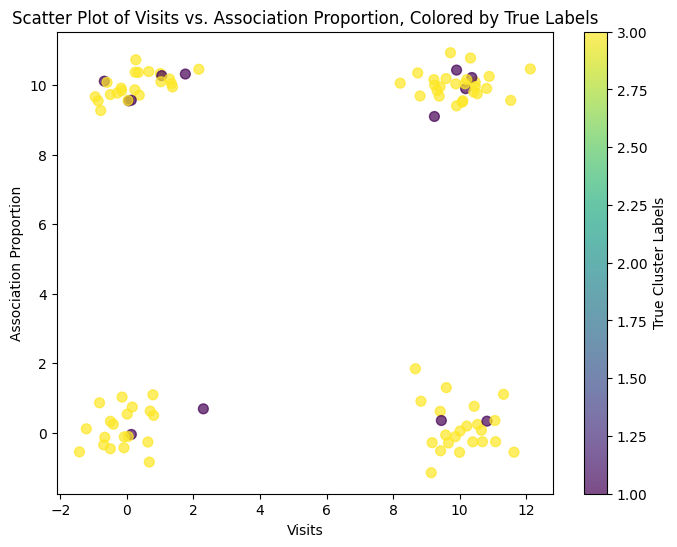

[[25.1 26.2 20.7 28. ]
 [22.3 28.1 21.8 27.8]
 [23.5 25.9 19.1 31.5]
 [21.4 26.2 25.  27.4]
 [25.  24.3 21.7 29. ]
 [24.2 26.7 20.9 28.2]
 [21.3 26.  22.5 30.2]
 [24.3 24.4 23.5 27.8]
 [23.  27.3 22.7 27. ]
 [23.8 27.2 22.  27. ]
 [23.4 26.6 20.7 29.3]
 [21.8 26.  23.7 28.5]
 [23.5 26.2 20.4 29.9]
 [22.4 24.3 21.3 32. ]
 [25.4 24.8 19.5 30.3]
 [21.9 25.8 21.3 31. ]
 [24.1 25.8 24.  26.1]
 [23.7 26.6 19.5 30.2]
 [23.3 29.5 21.3 25.9]
 [23.3 25.9 20.4 30.4]
 [23.9 26.6 20.1 29.4]
 [22.7 26.8 21.2 29.3]
 [23.4 27.2 20.6 28.8]
 [24.2 25.  21.5 29.3]
 [23.6 26.5 22.  27.9]
 [25.7 25.  20.2 29.1]
 [22.1 26.9 21.5 29.5]
 [22.5 30.  20.1 27.4]
 [24.5 28.1 20.5 26.9]
 [25.2 26.2 21.1 27.5]
 [23.4 27.3 21.3 28. ]
 [23.4 25.8 20.1 30.7]
 [24.6 25.2 22.  28.2]
 [22.4 25.3 23.4 28.9]
 [22.7 25.3 19.4 32.6]
 [24.8 27.7 19.5 28. ]
 [24.1 25.  22.2 28.7]
 [23.5 26.8 21.7 28. ]
 [24.5 27.4 20.8 27.3]
 [22.4 27.  23.4 27.2]
 [23.2 25.7 21.9 29.2]
 [22.9 26.9 23.1 27.1]
 [23.8 26.6 22.  27.6]
 [25.  26.6

In [9]:
import matplotlib.pyplot as plt
def cat_probs(tmp, max_category = 4):
    counts = jnp.bincount(tmp, length=max_category)  # Count occurrences of each category
    percentages = (counts / tmp.size) * 100
    return percentages

def analyze(sampler, data,  K=4):
    # Get posterior samples
    posterior_samples = sampler.get_samples()

    # Use Predictive to get cluster assignments
    predictive = Predictive(model, posterior_samples)
    predictions = predictive(jax.random.PRNGKey(1), data=data, K=K)
    predicted_assignments = predictions['assignment']

    # Calculate cluster probabilities
    #cluster_probs = jnp.mean(jax.nn.one_hot(predicted_assignments, K), axis=0)
    cluster_probs = vmap(lambda x: cat_probs(x), in_axes = 0)(predicted_assignments.T)
    
    # Get most likely cluster for each point
    final_assignments = jnp.argmax(cluster_probs, axis=1)

    plot_synthetic_data(data, final_assignments)
    
    # Calculate uncertainty
    assignment_uncertainty = 1 - jnp.max(cluster_probs, axis=1)
    print(cluster_probs)
    print("\nMean assignment uncertainty:", jnp.mean(assignment_uncertainty))

analyze(m.sampler, data, K=4)

# Numpyro without plates

In [ ]:
import numpyro.distributions as dists
from numpyro.ops.indexing import Vindex
def model(K, data=None, weight = 1):
    N, dim = data.shape
    cluster_proba = numpyro.sample('cluster_proba', dists.Dirichlet(weight * jnp.ones(K)))
    
    locs = numpyro.sample('locs', dists.MultivariateNormal(jnp.zeros(dim), 10 * jnp.eye(dim)).expand([K,dim]))
    sigma = numpyro.sample('sigma', dists.HalfCauchy(scale=10).expand([K, dim])) # TODO: Need to set up a different sigma for each axes.!!!!!!!!!!!!!!!!

    assignment = numpyro.sample('assignment', dists.Categorical(cluster_proba).expand([N]), infer={"enumerate": "parallel"})
        
    # Correctly broadcast sigma to create covariance matrices
    sigma_expanded = Vindex(sigma)[assignment][..., None, None] * jnp.eye(dim)
        
    numpyro.sample('obs',  dists.MultivariateNormal(Vindex(locs)[assignment], sigma_expanded), obs=data)

m.data_on_model = {'data':data, 'K':4}
m.run(model, num_warmup=1000, num_samples=1000, seed= 5)
m.sampler.print_summary() #p_real = [0.50, 0.10, 0.30, 0.10],

Dear All,
Up to my learning journey I manage to run my models without plate formulation by setting up parameters shapes but I know struggling with the GMM algorithm. I have multiples questions regarding plates in numpyro.
1. First, the plate version described in the following link is working : XXXX. But the sigma parameter is of shape 1 while it should be of shape of the number of features. How can I set-up this?
2. I tryed to run build the same model without plate formulation but it doesn't work despite the fact that my parameters have the correct shape as I use the same process to generate the data. Di d I miss something or do inferences be done without plate? This is the model : XXXX
3. 



I am trying to run the GMM algorithm.  While, I am not able to run the GMM algorithm with the plate formulation. I have tried to follow the example in the following link: